In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import IPython

import pandas as pd
import konlpy
import gensim

from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import Constant
from utils import *

1) 데이터 준비와 확인

In [2]:
# load data
train_data = pd.read_table('~/aiffel/sentiment_analysis/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_analysis/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) dataloader 구성

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
# check number of samples
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

# check sample of naver review
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

훈련 샘플 개수: 146182, 테스트 개수: 49157
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(word_to_index)

{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '서': 1

3) 모델 구성을 위한 데이터 분석 및 가공  
- 데이터셋 내 문장 길이 분포  
- 적절한 최대 문장 길이 지정  
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 이상치 제거
maxlen = int(np.mean(num_tokens) + 2.5 * np.std(num_tokens))
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens)} %가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  48
전체 문장의 0.9521754488351021 %가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


4) 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [8]:
# validation set 분리
val_len = int(X_train.shape[0]//5)

X_val = X_train[:val_len]   
y_val = y_train[:val_len]

# validation set을 제외한 나머지
X_train = X_train[val_len:]
y_train = y_train[val_len:]

print(X_train.shape)
print(y_train.shape)

(116946, 48)
(116946,)


In [9]:
vocab_size = 9997    # 어휘 사전의 크기입니다(3~9999의 인덱스 범위)
embed_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# lstm model
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size, embed_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(16))
lstm.add(tf.keras.layers.Dense(16, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         999700    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,007,477
Trainable params: 1,007,477
Non-trainable params: 0
_________________________________________________________________


5) 모델 훈련

In [18]:
checkpoint = ModelCheckpoint("models/lstm_weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

In [14]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10

history = lstm.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/10
229/229 [==============================] - 5s 8ms/step - loss: 0.4700 - accuracy: 0.7776 - val_loss: 0.3567 - val_accuracy: 0.8480

Epoch 00001: val_accuracy improved from -inf to 0.84800, saving model to models/lstm_weights.h5
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3328 - accuracy: 0.8600 - val_loss: 0.3435 - val_accuracy: 0.8509

Epoch 00002: val_accuracy improved from 0.84800 to 0.85094, saving model to models/lstm_weights.h5
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3064 - accuracy: 0.8727 - val_loss: 0.3398 - val_accuracy: 0.8531

Epoch 00003: val_accuracy improved from 0.85094 to 0.85313, saving model to models/lstm_weights.h5
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2881 - accuracy: 0.8805 - val_loss: 0.3416 - val_accuracy: 0.8525

Epoch 00004: val_accuracy did not improve from 0.85313
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.267

In [18]:
# load weights from 'lstm_weights.h5'
lstm.load_weights('models/lstm_weights.h5')

results = lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3606 - accuracy: 0.8495
[0.3606105446815491, 0.8494822978973389]


##### 다른 모델에 대한 실험 : RNN, GRU

i) RNN

In [21]:
# vanilla rnn model
rnn = tf.keras.Sequential()
rnn.add(tf.keras.layers.Embedding(vocab_size, embed_dim, input_shape=(None,)))
rnn.add(tf.keras.layers.SimpleRNN(16))
rnn.add(tf.keras.layers.Dense(16, activation='relu'))
rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         999700    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                1872      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,001,861
Trainable params: 1,001,861
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint = ModelCheckpoint("models/rnn_weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

In [23]:
rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10

history = rnn.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/10
229/229 [==============================] - 10s 41ms/step - loss: 0.4988 - accuracy: 0.7497 - val_loss: 0.3688 - val_accuracy: 0.8400

Epoch 00001: val_accuracy improved from -inf to 0.83996, saving model to models/rnn_weights.h5
Epoch 2/10
229/229 [==============================] - 9s 40ms/step - loss: 0.3416 - accuracy: 0.8572 - val_loss: 0.3563 - val_accuracy: 0.8477

Epoch 00002: val_accuracy improved from 0.83996 to 0.84772, saving model to models/rnn_weights.h5
Epoch 3/10
229/229 [==============================] - 9s 39ms/step - loss: 0.3030 - accuracy: 0.8752 - val_loss: 0.3621 - val_accuracy: 0.8470

Epoch 00003: val_accuracy did not improve from 0.84772
Epoch 4/10
229/229 [==============================] - 9s 40ms/step - loss: 0.2739 - accuracy: 0.8905 - val_loss: 0.3726 - val_accuracy: 0.8451

Epoch 00004: val_accuracy did not improve from 0.84772
Epoch 5/10
229/229 [==============================] - 9s 40ms/step - loss: 0.2457 - accuracy: 0.9048 - val_loss: 0.3839 

In [25]:
# load weights from 'rnn_weights.h5'
rnn.load_weights('models/rnn_weights.h5')

results = rnn.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3684 - accuracy: 0.8420
[0.36843544244766235, 0.8419756889343262]


ii) GRU

In [11]:
# gru model
gru = tf.keras.Sequential()
gru.add(tf.keras.layers.Embedding(vocab_size, embed_dim, input_shape=(None,)))
gru.add(tf.keras.layers.GRU(16))
gru.add(tf.keras.layers.Dense(16, activation='relu'))
gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         999700    
_________________________________________________________________
gru (GRU)                    (None, 16)                5664      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,005,653
Trainable params: 1,005,653
Non-trainable params: 0
_________________________________________________________________


In [12]:
checkpoint = ModelCheckpoint("models/gru_weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

In [13]:
gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10

history = gru.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/10
229/229 [==============================] - 5s 8ms/step - loss: 0.4498 - accuracy: 0.7890 - val_loss: 0.3492 - val_accuracy: 0.8482

Epoch 00001: val_accuracy improved from -inf to 0.84824, saving model to models/gru_weights.h5
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3269 - accuracy: 0.8618 - val_loss: 0.3393 - val_accuracy: 0.8533

Epoch 00002: val_accuracy improved from 0.84824 to 0.85330, saving model to models/gru_weights.h5
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2996 - accuracy: 0.8760 - val_loss: 0.3350 - val_accuracy: 0.8562

Epoch 00003: val_accuracy improved from 0.85330 to 0.85620, saving model to models/gru_weights.h5
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2777 - accuracy: 0.8861 - val_loss: 0.3319 - val_accuracy: 0.8602

Epoch 00004: val_accuracy improved from 0.85620 to 0.86024, saving model to models/gru_weights.h5
Epoch 5/10
229/229 [===================

In [14]:
# load weights from 'rnn_weights.h5'
gru.load_weights('models/gru_weights.h5')

results = gru.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3445 - accuracy: 0.8526
[0.3444684147834778, 0.8526151180267334]


6) Loss, Accuracy 시각화

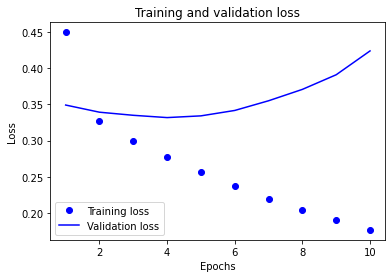

In [15]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

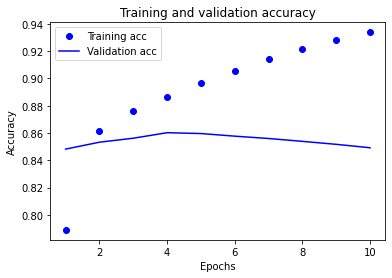

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [11]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load('/aiffel/aiffel/sentiment_analysis/data/word2vec_ko.model')
vector = word_vectors.wv["영화"]
print(len(vector))

100


In [12]:
vocab_size = 9997
embed_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.zeros((vocab_size, embed_dim))

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [11]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 embed_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           999700    
_________________________________________________________________
bidirectional (Bidirectional (None, 48, 32)            11328     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 48, 32)            4800      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,021,173
Trainable params: 1,021,173
Non-trainable params: 0
______________________________________________

In [46]:
# checkpoint callback 정의
checkpoint = ModelCheckpoint("models/weights_wordembedding.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=[checkpoint])

Epoch 1/20
229/229 [==============================] - 13s 25ms/step - loss: 0.5003 - accuracy: 0.7509 - val_loss: 0.4011 - val_accuracy: 0.8212

Epoch 00001: val_accuracy improved from -inf to 0.82121, saving model to models/weights_wordembedding.h5
Epoch 2/20
229/229 [==============================] - 4s 19ms/step - loss: 0.3658 - accuracy: 0.8393 - val_loss: 0.3495 - val_accuracy: 0.8471

Epoch 00002: val_accuracy improved from 0.82121 to 0.84707, saving model to models/weights_wordembedding.h5
Epoch 3/20
229/229 [==============================] - 4s 19ms/step - loss: 0.3216 - accuracy: 0.8619 - val_loss: 0.3341 - val_accuracy: 0.8527

Epoch 00003: val_accuracy improved from 0.84707 to 0.85268, saving model to models/weights_wordembedding.h5
Epoch 4/20
229/229 [==============================] - 4s 19ms/step - loss: 0.2947 - accuracy: 0.8760 - val_loss: 0.3288 - val_accuracy: 0.8570

Epoch 00004: val_accuracy improved from 0.85268 to 0.85703, saving model to models/weights_wordembeddi

In [47]:
# 테스트셋을 통한 모델 평가
model.load_weights('models/weights_wordembedding.h5')

results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.3385 - accuracy: 0.8570
[0.3384675681591034, 0.8570091724395752]


- GRU : 84.8%  
- GRU + Bidirectional : 85.05%
- GRU + Bidirectional + layer 2개 : 85.22%
- GRU + Bidirectional + layer 3개 : 85.7%
- GRU + Bidirectional + layer 4개 : 85.45%

##### 모델 최적화 with Keras Tuner

In [13]:
!pip install -q -U keras-tuner

In [14]:
import keras_tuner as kt

In [24]:
def gru_builder(hp):
    model = tf.keras.Sequential()
    
    hp_units = hp.Int('units', min_value = 8, max_value = 64, step = 8)
    model.add(tf.keras.layers.Embedding(vocab_size,
                                        embed_dim,
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_length=maxlen, 
                                        trainable=True))   
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp_units, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp_units, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp_units)))
    model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
    
    hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [35]:
tuner = kt.BayesianOptimization(gru_builder,
                                objective = 'val_accuracy', 
                                max_trials=10,
                               project_name = 'gru_tuning')

In [37]:
# checkpoint callback 정의
checkpoint = ModelCheckpoint("models/weights_wordembedding_kt.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

In [38]:
tuner.search(X_train, y_train, 
             epochs=10, 
             validation_data=(X_val, y_val), 
             batch_size = 512,
             callbacks=[ClearTrainingOutput(), checkpoint])

Trial 10 Complete [00h 01m 22s]
val_accuracy: 0.8687918782234192

Best val_accuracy So Far: 0.8698180317878723
Total elapsed time: 00h 11m 57s


In [40]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("best units: ", best_hps.get('units'),
      "\nbest lr:", best_hps.get('learning_rate'))

best units:  56 
best lr: 0.001


In [42]:
# load and train optimal model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train,
                y_train,
                epochs=20,
                batch_size=512,
                validation_data=(X_val, y_val),
                verbose=1,
                callbacks=[checkpoint])

Epoch 1/20
229/229 [==============================] - 16s 40ms/step - loss: 0.4581 - accuracy: 0.7790 - val_loss: 0.3694 - val_accuracy: 0.8338

Epoch 00001: val_accuracy improved from -inf to 0.83384, saving model to models/weights_wordembedding_kt.h5
Epoch 2/20
229/229 [==============================] - 6s 28ms/step - loss: 0.3339 - accuracy: 0.8545 - val_loss: 0.3339 - val_accuracy: 0.8537

Epoch 00002: val_accuracy improved from 0.83384 to 0.85374, saving model to models/weights_wordembedding_kt.h5
Epoch 3/20
229/229 [==============================] - 6s 28ms/step - loss: 0.2900 - accuracy: 0.8769 - val_loss: 0.3132 - val_accuracy: 0.8640

Epoch 00003: val_accuracy improved from 0.85374 to 0.86400, saving model to models/weights_wordembedding_kt.h5
Epoch 4/20
229/229 [==============================] - 7s 29ms/step - loss: 0.2595 - accuracy: 0.8907 - val_loss: 0.3121 - val_accuracy: 0.8677

Epoch 00004: val_accuracy improved from 0.86400 to 0.86773, saving model to models/weights_wo

In [43]:
best_model.load_weights("models/weights_wordembedding_kt.h5")

results = best_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.3216 - accuracy: 0.8644
[0.32155701518058777, 0.8643530011177063]


- GRU + Bidirectional + layer 3개 + 한국어 임베딩 + 하이퍼파라미터 튜닝 : 86.44%

#### 개선한 사항
1) Bidirectional 적용하고 layer 개수 조절하면서 실험  
2) keras tuner를 활용한 최적화 
- units
- learning rate